## author: Levon Abramian, J4132
## Task 3. Algorithms for unconstrained nonlinear optimization. First- and second-order methods

## The use of first- and second-order methods (Gradient Descent, Non-linear, Conjugate Gradient Descent, Newton’s method and Levenberg-Marquardt algorithm) in the tasks of unconstrained nonlinear optimization

In [1]:
import math
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
import random
import scipy
from scipy.optimize import minimize, least_squares

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm

In [2]:
EPS = 0.001

In [3]:
alpha = random.random()
beta = random.random()
sigma = np.random.normal(size=101)
x_list = np.linspace(0, 1, 101)
y_list = alpha * x_list + beta + sigma

In [4]:
alpha, beta

(0.2933315259195769, 0.5976873028910265)

In [5]:
def linear_approximation(x, a, b):
    return a * x + b


def rational_approximation(x, a, b):
    return a / (1 + b * x)


In [6]:
def loss_linear(params, x, y):
    a, b = params
    predictions = linear_approximation(x, a, b)
    return np.sum((predictions - y) ** 2)


def loss_rational(params, x, y):
    a, b = params
    predictions = rational_approximation(x, a, b)
    return np.sum((predictions - y) ** 2)


In [7]:
# Jacobian of the loss function for Newton's Method
def linear_jacobian(params, x, y):
    a, b = params
    predictions = linear_approximation(x, a, b)
    errors = predictions - y
    da = 2 * np.sum(errors * x)  # dD/da
    db = 2 * np.sum(errors)  # dD/db
    return np.array([da, db])


def rational_jacobian(params, x, y):
    a, b = params
    predictions = rational_approximation(x, a, b)
    errors = predictions - y
    da = 2 * np.sum(errors / (1 + b * x))  # dD/da
    db = 2 * np.sum(errors * (-a * x) / (1 + b * x) ** 2)  # dD/db
    return np.array([da, db])
    

In [8]:
def linear_gradient_descent(x, y, initial_params, lr=0.001, eps=EPS):
    param = np.array(initial_params, dtype=float)  # Ensure params are floats
    steps = []
    steps.append(param)
    for _ in range(10000):  # Limit iterations to prevent infinite loops
        predictions = linear_approximation(x, param[0], param[1])
        errors = predictions - y
        gradient = np.array([
            2 * np.sum(errors * x),  # dL/da
            2 * np.sum(errors)  # dL/db
        ])
        param = param - lr * gradient
        steps.append(param)
        # Check for convergence
        if np.linalg.norm(gradient) < eps:
            break
    return param, steps


def rational_gradient_descent(x, y, initial_params, lr=0.001, eps=EPS):
    param = np.array(initial_params, dtype=float)  # Ensure params are floats
    steps = []
    steps.append(param)
    print(initial_params)
    for _ in range(10000):  # Limit iterations to prevent infinite loops
        predictions = rational_approximation(x, param[0], param[1])
        errors = predictions - y
        gradient = np.array([
            2 * np.sum(errors / (1 + param[1] * x)),  # dL/da
            2 * np.sum(errors * (-param[0] * x) / (1 + param[1] * x) ** 2)  # dL/db
        ])
        param = param - lr * gradient
        steps.append(param)
        # Check for convergence
        if np.linalg.norm(gradient) < eps:
            break
    return param, steps


In [9]:
# Non-linear Conjugate Gradient Descent
def linear_nonlinear_conjugate_gradient(x, y, initial_params):
    result = minimize(loss_linear, initial_params, args=(x, y), method='CG', tol=0.001, options={'gtol':10**-6, 'disp':True, 'return_all':True})
    return result


def rational_nonlinear_conjugate_gradient(x, y, initial_params):
    result = minimize(loss_rational, initial_params, args=(x, y), method='CG', tol=0.001, options={'gtol':10**-6, 'disp':True, 'return_all':True})
    return result
    

In [10]:
# Newton's Method with Jacobian
def linear_newtons_method(x, y, initial_params):
    result = minimize(loss_linear, initial_params, args=(x, y), method='BFGS', jac=linear_jacobian, tol=0.001, options={'gtol':10**-6, 'disp':True, 'return_all':True})
    return result

# Newton's Method with Jacobian
def rational_newtons_method(x, y, initial_params):
    result = minimize(loss_rational, initial_params, args=(x, y), method='BFGS', jac=rational_jacobian, tol=0.001, options={'gtol':10**-6, 'disp':True, 'return_all':True})
    return result
    

In [55]:
# Newton's Method with Jacobian
def linear_neldermead_method(x, y, initial_params):
    result = minimize(loss_linear, initial_params, args=(x, y), method='Nelder-Mead', jac=linear_jacobian, tol=0.001, options={'gtol':10**-6, 'disp':True, 'return_all':True})
    return result

# Newton's Method with Jacobian
def rational_neldermead_method(x, y, initial_params):
    result = minimize(loss_rational, initial_params, args=(x, y), method='Nelder-Mead', jac=rational_jacobian, tol=0.001, options={'gtol':10**-6, 'disp':True, 'return_all':True})
    return result
    

In [69]:
class Point:

    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __add__(self, other):
        x = self.x + other.x
        y = self.y + other.y
        return Point(x, y)

    def __hash__(self):
        return 1

    def __str__(self):
        return f'{self.x}, {self.y}'

    def __repr__(self):
        return f'{self.x}, {self.y}'

    def __rmul__(self, other):
        x = self.x * other
        y = self.y * other
        return Point(x, y)

    def __truediv__(self, other):
        x = self.x / other
        y = self.y / other
        return Point(x, y)

    def __sub__(self, other):
        x = self.x - other.x
        y = self.y - other.y
        return Point(x, y)


def D(a, b, F):
    D = 0
    for xi, yi in zip(x_list, y_list):
        D += (F(xi, a, b) - yi) ** 2
    return D

def exhaustive_search_2D(func, start_point: Point, finish_point: Point, eps, F):
    min_point, min_value = start_point, func(start_point.x, start_point.y, F)

    current_point = start_point
    n_iter = 0
    
    while finish_point.x - current_point.x > eps:
        while finish_point.y - current_point.y > eps:
            n_iter += 1
    
            current_value = func(current_point.x, current_point.y, F)
            
            if current_value < min_value:
                min_point, min_value = current_point, current_value
            
            current_point = Point(current_point.x, current_point.y + eps)

        current_point = Point(current_point.x + eps, start_point.y)

    return min_point, n_iter

In [85]:
def dichotomy_search(func, a, b, eps):
    n_iter = 0
    
    while abs(a - b) > eps:
        n_iter += 1
        
        if func(a) < func(b):
            b = (a + b) / 2
        else:
            a = (a + b) / 2

    return (a + b) / 2, n_iter

def gauss_search(func, start_point: Point, finish_point: Point, eps, F):
    optim_point = start_point
    n_iter = 0
    cur_min_value = func(start_point.x, start_point.y, F)
    while True:
        cur_func = lambda x: func(optim_point.x, x, F)
        y_inner_point, iters = dichotomy_search(cur_func, start_point.y, finish_point.y, eps)
        n_iter += iters
        if abs(optim_point.y - y_inner_point) < eps:
            break
        
        optim_point = Point(optim_point.x, y_inner_point)

        cur_func =  lambda x: func(x, optim_point.y, F)
        x_inner_point, iters = dichotomy_search(cur_func, start_point.x, finish_point.x, eps)
        n_iter += iters
        if abs(optim_point.x - x_inner_point) < eps:
            break
        optim_point = Point(x_inner_point, optim_point.y)
    
    return optim_point, n_iter

In [11]:
# Levenberg-Marquardt
def linear_levenberg_marquardt(x, y, initial_params):
    def residuals(params):
        return linear_approximation(x, params[0], params[1]) - y
    
    result = least_squares(residuals, initial_params, method='lm', verbose=1)
    
    return result


# Levenberg-Marquardt
def rational_levenberg_marquardt(x, y, initial_params):
    def residuals(params):
        return rational_approximation(x, params[0], params[1]) - y
    
    result = least_squares(residuals, initial_params, method='lm', verbose=1)
    
    return result

Gradient Descent parameters: a=0.3602, b=0.3869


Text(0.5, 1.0, 'Linear Approximation Gradient Descent')

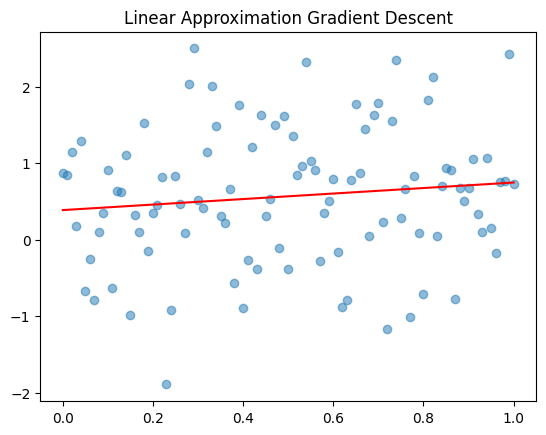

In [12]:
# Initial parameter guesses
initial_params = [0.1, 0.1]

linear_params_gd, list_linear_params_gd = linear_gradient_descent(x_list, y_list, initial_params)

print(f"Gradient Descent parameters: a={linear_params_gd[0]:.4f}, b={linear_params_gd[1]:.4f}")

plt.scatter(x_list, y_list, label='Noisy Data', alpha=0.5)
plt.plot(x_list, linear_approximation(x_list, *linear_params_gd), color='red', label='Gradient Descent Fit')
plt.title('Linear Approximation Gradient Descent')

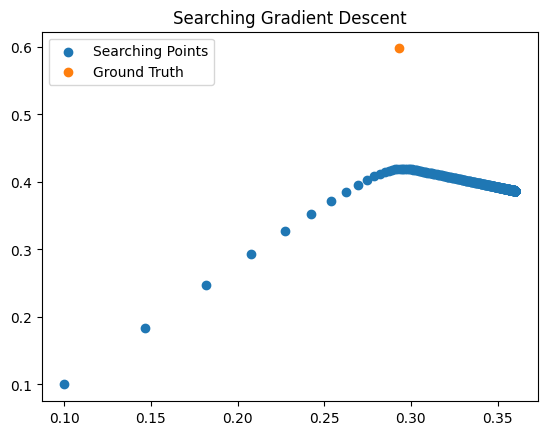

In [13]:
xs = [point[0] for point in list_linear_params_gd]
ys = [point[1] for point in list_linear_params_gd]
plt.scatter(xs, ys, label='Searching Points')
plt.scatter(alpha, beta, label='Ground Truth')
plt.title('Searching Gradient Descent')
plt.legend()

[0.1, 0.1]
Gradient Descent parameters: a=0.4378, b=-0.4199


Text(0.5, 1.0, 'Rational Approximation Gradient Descent')

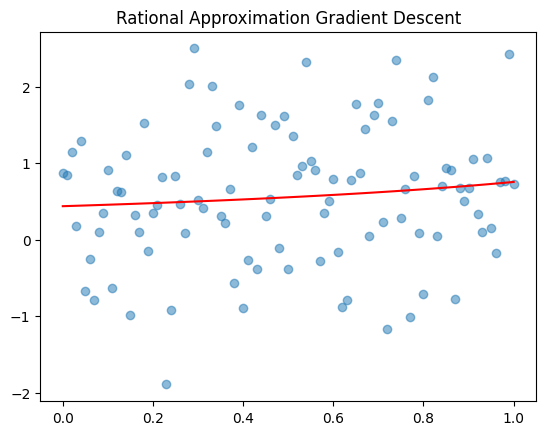

In [14]:
# Initial parameter guesses
initial_params = [0.1, 0.1]

rational_params_gd, list_rational_params_gd = rational_gradient_descent(x_list, y_list, initial_params)

print(f"Gradient Descent parameters: a={rational_params_gd[0]:.4f}, b={rational_params_gd[1]:.4f}")

plt.scatter(x_list, y_list, label='Noisy Data', alpha=0.5)
plt.plot(x_list, rational_approximation(x_list, *rational_params_gd), color='red', label='Gradient Descent Fit')
plt.title('Rational Approximation Gradient Descent')

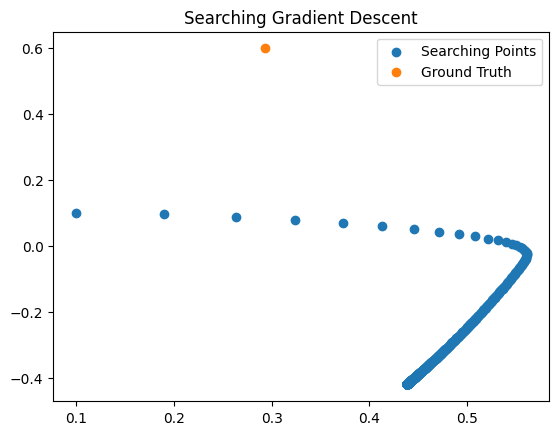

In [15]:
xs = [point[0] for point in list_rational_params_gd]
ys = [point[1] for point in list_rational_params_gd]
plt.scatter(xs, ys, label='Searching Points')
plt.scatter(alpha, beta, label='Ground Truth')
plt.title('Searching Gradient Descent')
plt.legend()

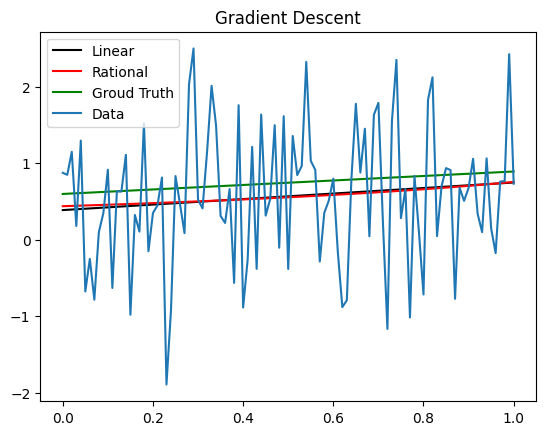

In [16]:
plt.plot(x_list, linear_approximation(x_list, *linear_params_gd), color='black', label='Linear')
plt.plot(x_list, rational_approximation(x_list, *rational_params_gd), color='red', label='Rational')
plt.plot(x_list, linear_approximation(x_list, alpha, beta), color='green', label='Groud Truth')
plt.title('Gradient Descent')
plt.plot(x_list, y_list, label='Data')
plt.legend()

Optimization terminated successfully.
         Current function value: 77.764762
         Iterations: 2
         Function evaluations: 15
         Gradient evaluations: 5


Text(0.5, 1.0, 'Linear Approximation Nonlinear Conjugate Gradient')

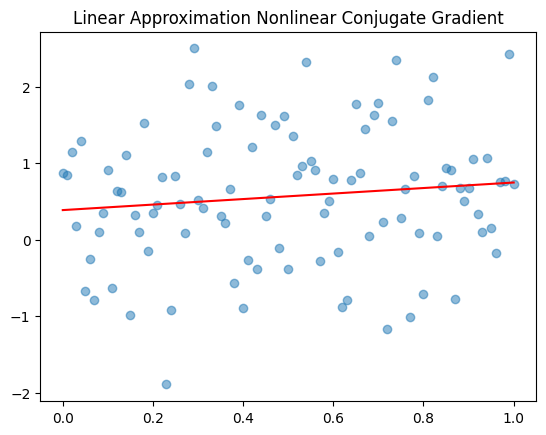

In [17]:
linear_cg_params = linear_nonlinear_conjugate_gradient(x_list, y_list, initial_params)

plt.scatter(x_list, y_list, label='Noisy Data', alpha=0.5)
plt.plot(x_list, linear_approximation(x_list, *linear_cg_params.x), color='red', label='Gradient Descent Fit')
plt.title('Linear Approximation Nonlinear Conjugate Gradient')

In [18]:
linear_cg_params.allvecs

[array([0.1, 0.1]),
 array([0.28188467, 0.42887422]),
 array([0.36022602, 0.38681853])]

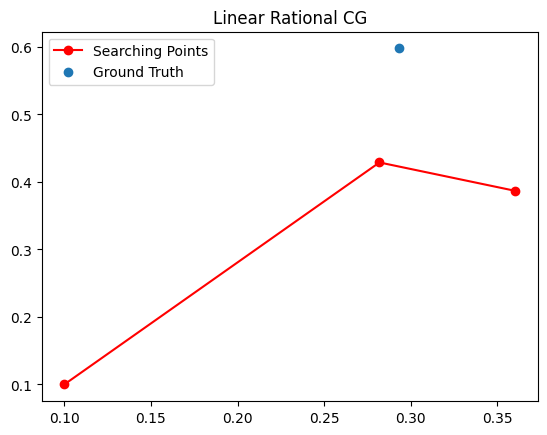

In [19]:
xs = [point[0] for point in linear_cg_params.allvecs]
ys = [point[1] for point in linear_cg_params.allvecs]
plt.plot(xs, ys, label='Searching Points', marker='o', color='r')
plt.scatter(alpha, beta, label='Ground Truth')
plt.title('Linear Rational CG')
plt.legend()

Optimization terminated successfully.
         Current function value: 77.918924
         Iterations: 12
         Function evaluations: 87
         Gradient evaluations: 29


Text(0.5, 1.0, 'Rational Approximation Nonlinear Conjugate Gradient')

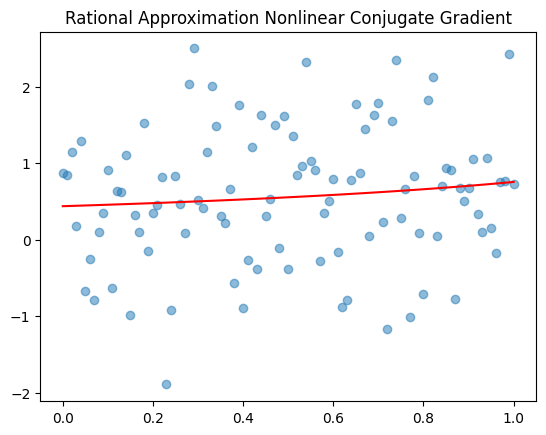

In [20]:
rational_cg_params = rational_nonlinear_conjugate_gradient(x_list, y_list, initial_params)

plt.scatter(x_list, y_list, label='Noisy Data', alpha=0.5)
plt.plot(x_list, rational_approximation(x_list, *rational_cg_params.x), color='red', label='Gradient Descent Fit')
plt.title('Rational Approximation Nonlinear Conjugate Gradient')

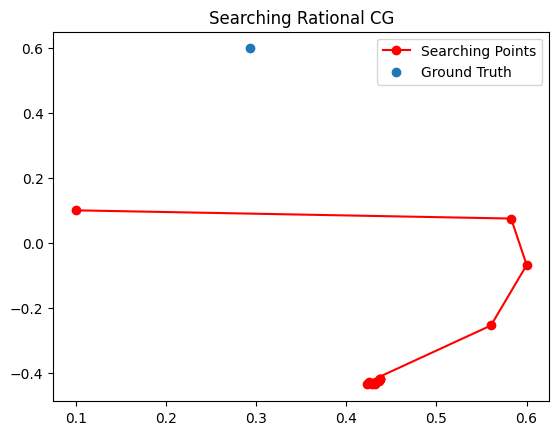

In [21]:
xs = [point[0] for point in rational_cg_params.allvecs]
ys = [point[1] for point in rational_cg_params.allvecs]
plt.plot(xs, ys, label='Searching Points', marker='o', color='r')
plt.scatter(alpha, beta, label='Ground Truth')
plt.title('Searching Rational CG')
plt.legend()

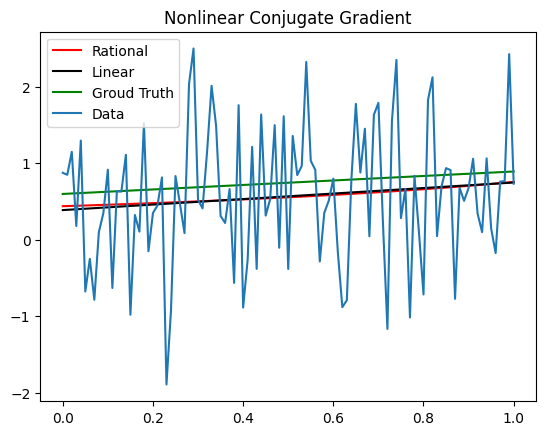

In [22]:
# plt.scatter(x_list, y_list, label='Noisy Data', alpha=0.5)
plt.plot(x_list, rational_approximation(x_list, *rational_cg_params.x), color='red', label='Rational')
plt.plot(x_list, linear_approximation(x_list, *linear_cg_params.x), color='black', label='Linear')
plt.plot(x_list, linear_approximation(x_list, alpha, beta), color='green', label='Groud Truth')
plt.title('Nonlinear Conjugate Gradient')
plt.plot(x_list, y_list, label='Data')
plt.legend()

Optimization terminated successfully.
         Current function value: 77.764762
         Iterations: 2
         Function evaluations: 5
         Gradient evaluations: 5


Text(0.5, 1.0, 'Linear Approximation Newton')

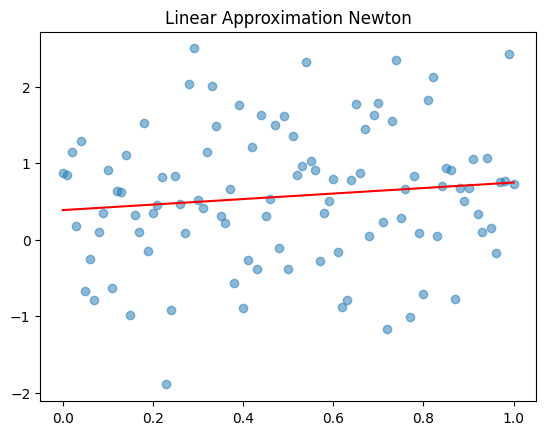

In [23]:
linear_newton_params = linear_newtons_method(x_list, y_list, initial_params)

plt.scatter(x_list, y_list, label='Noisy Data', alpha=0.5)
plt.plot(x_list, linear_approximation(x_list, *linear_newton_params.x), color='red', label='Gradient Descent Fit')
plt.title('Linear Approximation Newton')

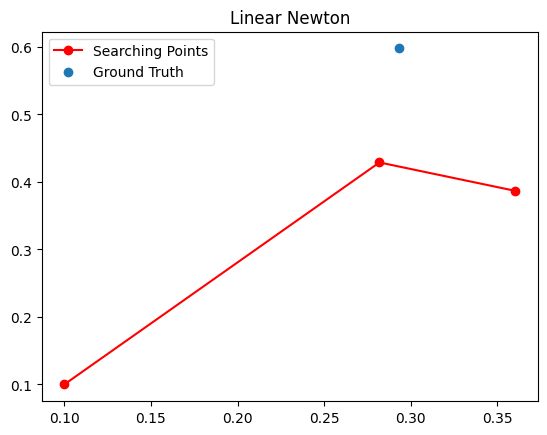

In [24]:
xs = [point[0] for point in linear_newton_params.allvecs]
ys = [point[1] for point in linear_newton_params.allvecs]
plt.plot(xs, ys, label='Searching Points', marker='o', color='r')
plt.scatter(alpha, beta, label='Ground Truth')
plt.title('Linear Newton')
plt.legend()

Optimization terminated successfully.
         Current function value: 77.918924
         Iterations: 12
         Function evaluations: 17
         Gradient evaluations: 17


Text(0.5, 1.0, 'Rational Approximation Newton')

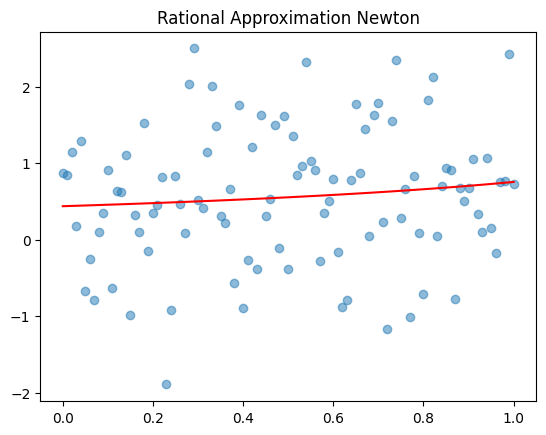

In [25]:
rational_newton_params = rational_newtons_method(x_list, y_list, initial_params)

plt.scatter(x_list, y_list, label='Noisy Data', alpha=0.5)
plt.plot(x_list, rational_approximation(x_list, *rational_newton_params.x), color='red', label='Gradient Descent Fit')
plt.title('Rational Approximation Newton')

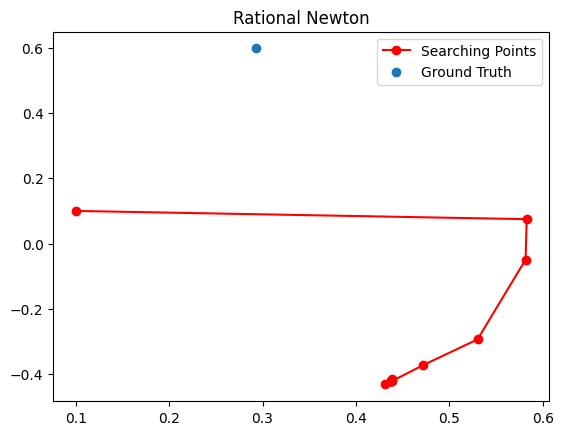

In [26]:
xs = [point[0] for point in rational_newton_params.allvecs]
ys = [point[1] for point in rational_newton_params.allvecs]
plt.plot(xs, ys, label='Searching Points', marker='o', color='r')
plt.scatter(alpha, beta, label='Ground Truth')
plt.title('Rational Newton')
plt.legend()

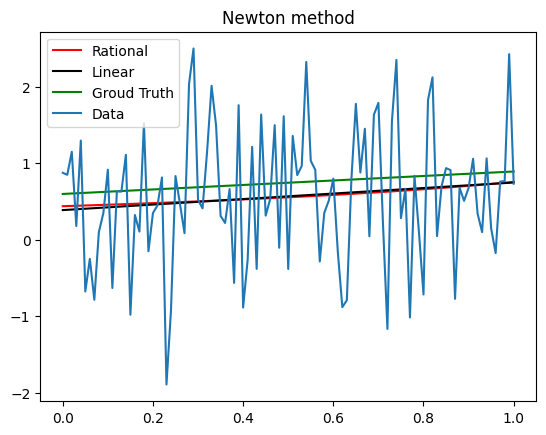

In [27]:
# plt.scatter(x_list, y_list, label='Noisy Data', alpha=0.5)
plt.plot(x_list, rational_approximation(x_list, *rational_newton_params.x), color='red', label='Rational')
plt.plot(x_list, linear_approximation(x_list, *linear_newton_params.x), color='black', label='Linear')
plt.plot(x_list, linear_approximation(x_list, alpha, beta), color='green', label='Groud Truth')
plt.title('Newton method')
plt.plot(x_list, y_list, label='Data')
plt.legend()

`ftol` termination condition is satisfied.
Function evaluations 7, initial cost 4.7952e+01, final cost 3.8882e+01, first-order optimality 3.50e-07.


Text(0.5, 1.0, 'Linear Approximation Levenberg-Marquardt')

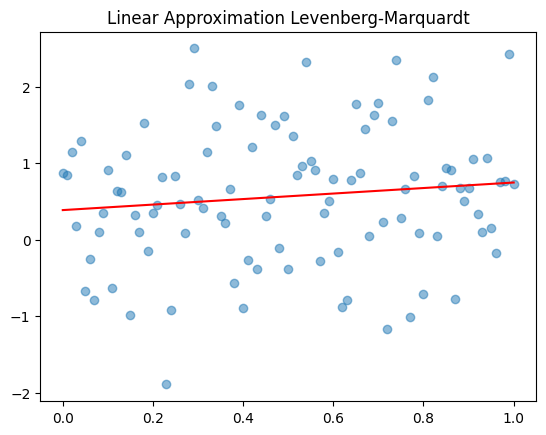

In [28]:
linear_lm_params = linear_levenberg_marquardt(x_list, y_list, initial_params)

plt.scatter(x_list, y_list, label='Noisy Data', alpha=0.5)
plt.plot(x_list, linear_approximation(x_list, *linear_lm_params.x), color='red', label='Gradient Descent Fit')
plt.title('Linear Approximation Levenberg-Marquardt')

`ftol` termination condition is satisfied.
Function evaluations 20, initial cost 5.0701e+01, final cost 3.8959e+01, first-order optimality 1.07e-04.


Text(0.5, 1.0, 'Rational Approximation Levenberg-Marquardt')

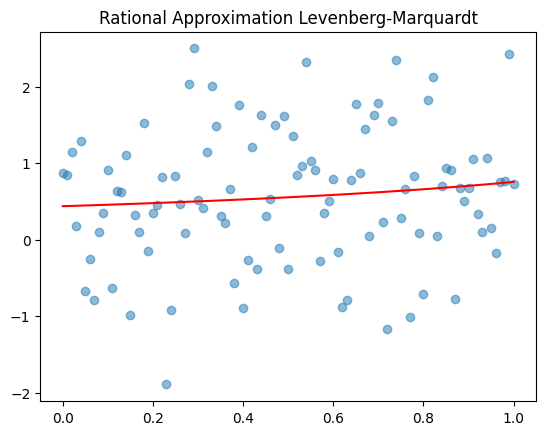

In [29]:
rational_lm_params = rational_levenberg_marquardt(x_list, y_list, initial_params)

plt.scatter(x_list, y_list, label='Noisy Data', alpha=0.5)
plt.plot(x_list, rational_approximation(x_list, *rational_lm_params.x), color='red', label='Gradient Descent Fit')
plt.title('Rational Approximation Levenberg-Marquardt')

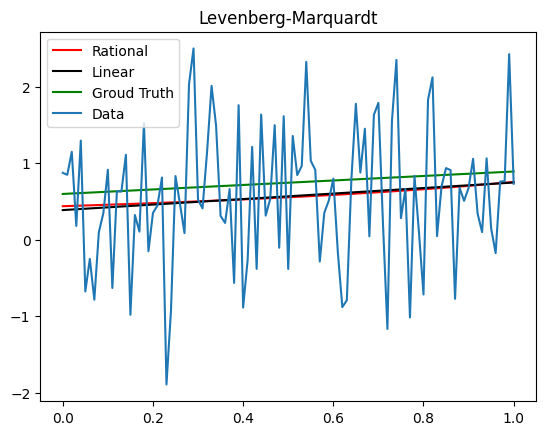

In [71]:
plt.plot(x_list, rational_approximation(x_list, *rational_lm_params.x), color='red', label='Rational')
plt.plot(x_list, linear_approximation(x_list, *linear_lm_params.x), color='black', label='Linear')
plt.plot(x_list, linear_approximation(x_list, alpha, beta), color='green', label='Groud Truth')
plt.title('Levenberg-Marquardt')
plt.plot(x_list, y_list, label='Data')
plt.legend()

In [57]:
linear_neldermead_params = linear_neldermead_method(x_list, y_list, initial_params)
rational_neldermead_params = rational_neldermead_method(x_list, y_list, initial_params)

Optimization terminated successfully.
         Current function value: 77.764767
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: 77.918925
         Iterations: 37
         Function evaluations: 70


In [70]:
min_point_exs_1, interation_exs_1 = exhaustive_search_2D(D, Point(0, 0), Point(1, 1), eps=0.001, F=linear_approximation)
min_point_exs_2, interation_exs_2 = exhaustive_search_2D(D, Point(0, 0), Point(1, 1), eps=0.001, F=rational_approximation)

In [86]:
min_point_gauss_1, interation_gauss_1 = gauss_search(D, Point(0, 0), Point(1, 1), eps=0.001, F=linear_approximation)
min_point_gauss_2, interation_gauss_2 = gauss_search(D, Point(0, 0), Point(1, 1), eps=0.001, F=rational_approximation)

# Comparision

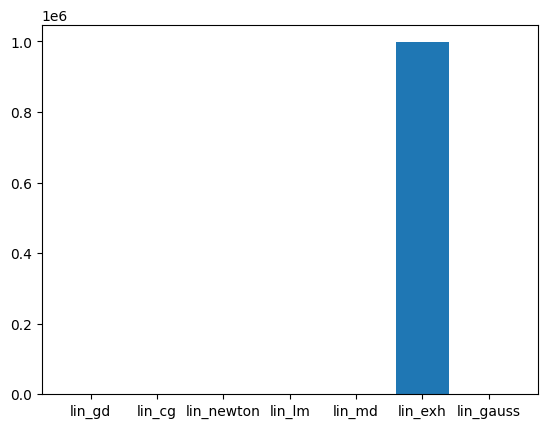

In [87]:
d_lin = {
    'lin_gd': len(list_linear_params_gd),
    'lin_cg': len(linear_cg_params.allvecs),
    'lin_newton': len(linear_newton_params.allvecs),
    'lin_lm': linear_lm_params.nfev,
    'lin_md': len(linear_neldermead_params.allvecs),
    'lin_exh': interation_exs_1,
    'lin_gauss': interation_gauss_1,
}
plt.bar(d_lin.keys(), d_lin.values());

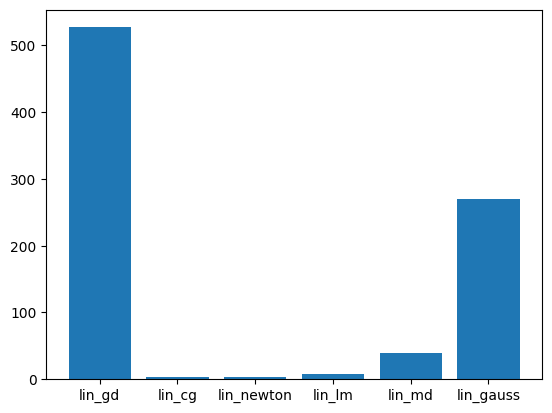

In [88]:
d_lin = {
    'lin_gd': len(list_linear_params_gd),
    'lin_cg': len(linear_cg_params.allvecs),
    'lin_newton': len(linear_newton_params.allvecs),
    'lin_lm': linear_lm_params.nfev,
    'lin_md': len(linear_neldermead_params.allvecs),
    # 'lin_exh': interation_exs_1
    'lin_gauss': interation_gauss_1
}
plt.bar(d_lin.keys(), d_lin.values());

In [89]:
d_rational = {
    'rat_gd': len(list_rational_params_gd),
    'rat_cg': len(rational_cg_params.allvecs),
    'rat_newton': len(rational_newton_params.allvecs),
    'rat_lm': rational_lm_params.nfev,
    'rat_md': len(linear_neldermead_params.allvecs),
    # 'rat_exh': interation_exs_2
    'rat_gauss': interation_gauss_2
}

<BarContainer object of 6 artists>

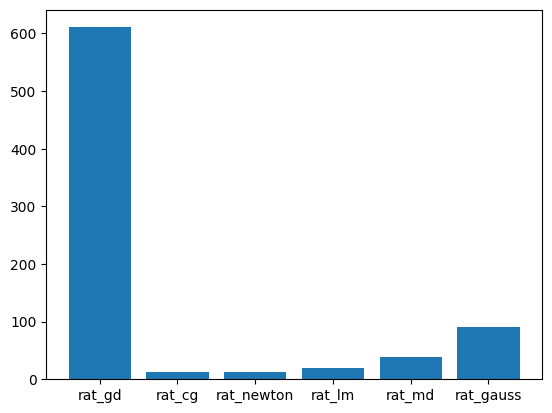

In [90]:
plt.bar(d_rational.keys(), d_rational.values())

# Conclusion